## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [92]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

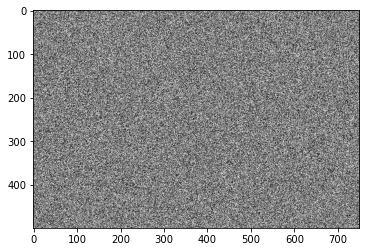

In [93]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [94]:
from sklearn.datasets import fetch_openml
digits = fetch_openml('mnist_784')
digits.data.shape

(70000, 784)

In [96]:
images = digits.data.reshape(-1, 28, 28)

Пример картинки из датасета:

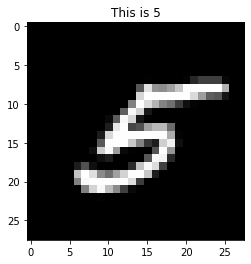

In [97]:
i = 985
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(70000, 50)

Дисперсии вдоль главных компонент:

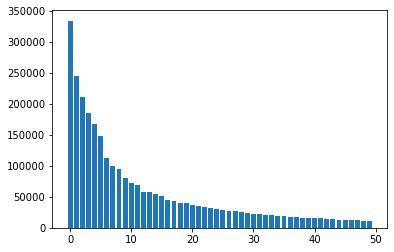

In [99]:
plt.bar(np.arange(50), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

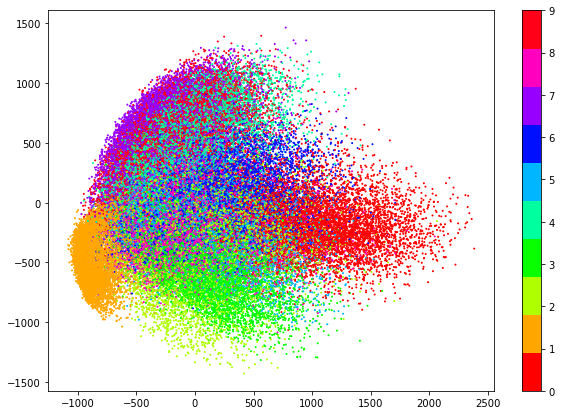

In [100]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [101]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(70000, 50)

И мы получаем ту же самую картинку:

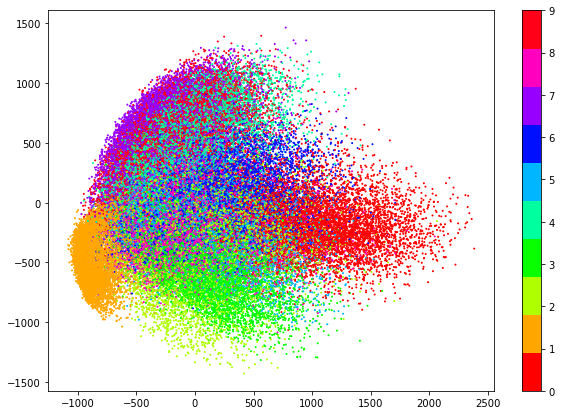

In [102]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

<IPython.core.display.Javascript object>


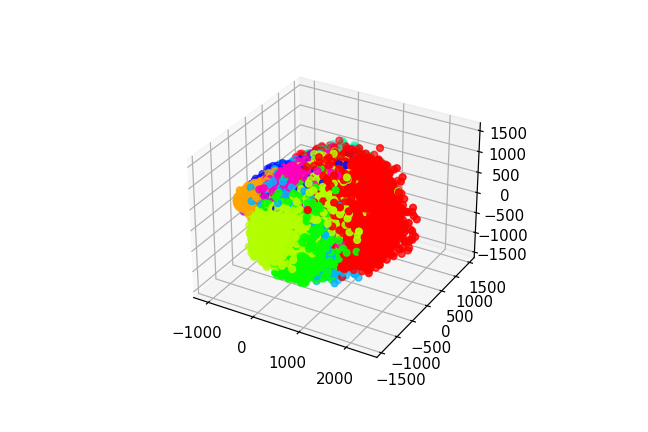

In [103]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

Теперь выполним обратное преобразование:

In [104]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(70000, 784)

Слева оригинал, справа - изображение, восстановленное из проекции

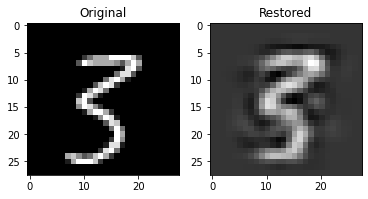

In [106]:
%matplotlib inline
i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

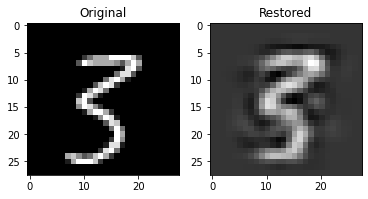

In [107]:
pca.fit

res = np.dot(X_transformed, pca.components_[:50,:]) + digits.data.astype(float).mean(axis=0)

i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 2

Определите, сколько нужно взять главных компонент, чтобы объяснить  99%, 95%, 90%, и 85% исходной дисперсии.


In [124]:
def n_comp(accuracy):
    pca = PCA(n_components = accuracy)
    X = pca.fit_transform(digits.data.astype(float))
    return pca.n_components_

print("99% of Explained Variance", n_comp(0.99), "Components")
print("95% of Explained Variance", n_comp(0.95), "Components")
print("90% of Explained Variance", n_comp(0.90), "Components")
print("85% of Explained Variance", n_comp(0.85), "Components")

99% of Explained Variance 331 Components
95% of Explained Variance 154 Components
90% of Explained Variance 87 Components
85% of Explained Variance 59 Components


### Задача 3

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

![img](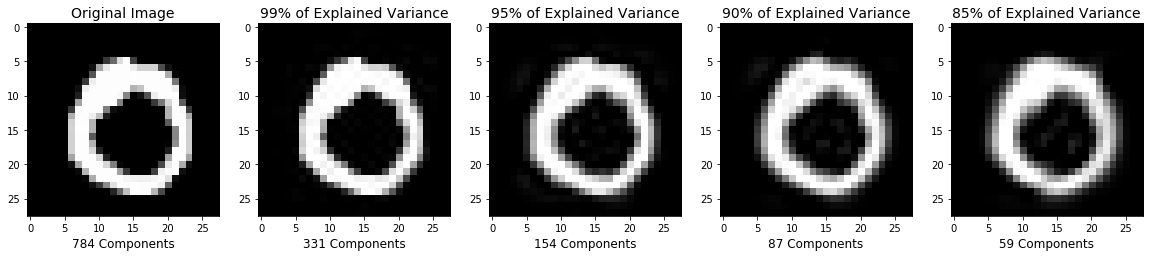%0A)

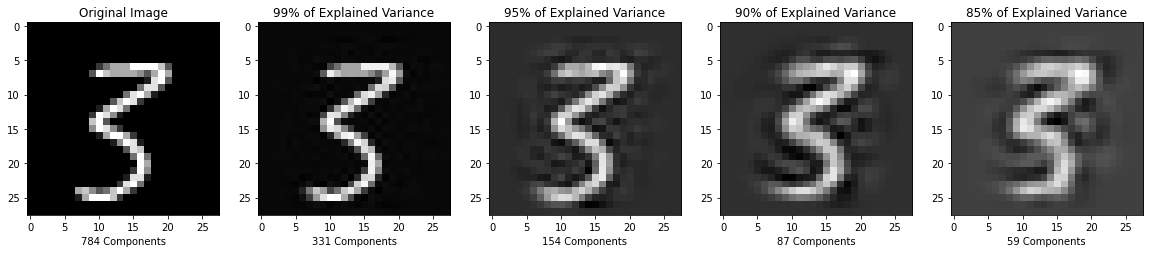

In [136]:
def inv(accuracy):
    pca = PCA(n_components = accuracy)
    X = pca.fit_transform(digits.data.astype(float))
    return pca.inverse_transform(X)

figure, ax = plt.subplots(1, 5, figsize=(20,12))

ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(inv(0.99)[i].reshape(28, 28), cmap='gray')
ax[2].imshow(inv(0.95)[i].reshape(28, 28), cmap='gray')
ax[3].imshow(inv(0.90)[i].reshape(28, 28), cmap='gray')
ax[4].imshow(inv(0.85)[i].reshape(28, 28), cmap='gray')

ax[0].set_title("Original Image")
ax[1].set_title("99% of Explained Variance")
ax[2].set_title("95% of Explained Variance")
ax[3].set_title("90% of Explained Variance")
ax[4].set_title("85% of Explained Variance")
ax[0].set_xlabel("784 Components")
ax[1].set_xlabel("331 Components")
ax[2].set_xlabel("154 Components")
ax[3].set_xlabel("87 Components")
ax[4].set_xlabel("59 Components")

plt.show()

### Задача 4

Предложите способ генерации новых изображений с числами и приведите примеры сгенерированных картинок.

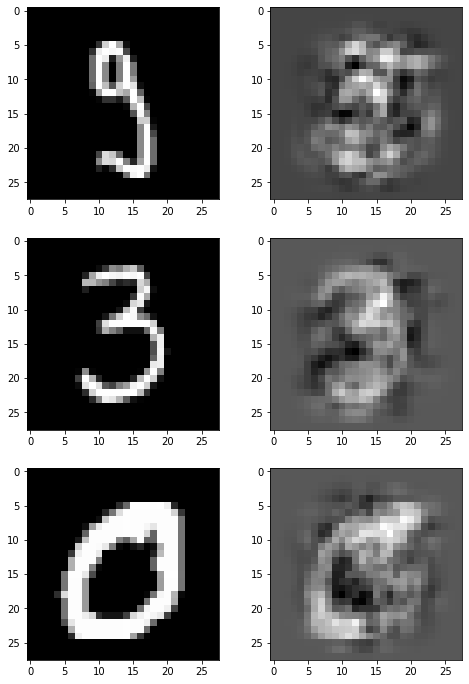

In [182]:
def swap(v, x, y): #Функция для swap-а столбцов матрицы
    t = v[:,x]
    v[:,x] = v[:,y]
    v[:,y] = t 
    
def deform(n): 
    pca = PCA(n_components=n)
    X = pca.fit_transform(digits.data.astype(float))

    for i in range(n-1):
        if (np.random.choice([0,1]) == 1): # случайным образом меняю соседние столбцы X
            swap(X, i, i+1)
    X_ = pca.inverse_transform(X)
    return X_

fig, ax = plt.subplots(3, 2,figsize=(8,12))
ax[0,0].imshow(images[48], cmap='gray')
ax[0,1].imshow(deform(250)[48].reshape(28,28),cmap='gray')
ax[1,0].imshow(images[50], cmap='gray')
ax[1,1].imshow(deform(251)[50].reshape(28,28),cmap='gray')
ax[2,0].imshow(images[51], cmap='gray')
ax[2,1].imshow(deform(352)[51].reshape(28,28),cmap='gray')
plt.show()

### Задача 5 (факультатив)
Можно ли построить представления датасета MNIST в 2D с более выраженным разделением кластеров отдельных цифр? For inspiration see https://colah.github.io/posts/2014-10-Visualizing-MNIST/

In [91]:
def findn(nleft,nright,k):
    if(nright-nleft==1):
        return nright
    n=(nleft+nright)//2
    pca=PCA(n_components=n)
    pca.fit(digits.data.astype(float))
    if(pca.explained_variance_ratio_.sum()<k):
        return findn(n,nright,k)
    else:
        return findn(nleft,n,k)